*This documentation and associated AI agent tutorial is released under the [MIT License](https://opensource.org/license/mit), which permits any type of modification and commercialization.*

# Interactive Notebook: Understanding the AI Agent Design and Aralia OpenRAG

This interactive notebook guides you through the process of designing AI agents tapping into the Aralia Open Data Ecosystem using the Aralia OpenRAG Library. Each section provides sample code and explanations to facilitate your exploration and development of AI agents.


Feel free to edit the code within this notebook, however, any changes will not be saved. If you'd like to save the changes, please first create a new copy.

Helpful comments are added to each code block (preceded with #). If you are required to input information, a comment (preceded with ##) will also inform you to do so. If this is your first time using this demo, we recommend following the flow of this demo, executing each code block one by one and fill in variables as needed.

If you would like to try out the results directly, please execute the cells under the **Setup** section, ensure there are no errors, and try it out in  **Section 2: AI Agent Workflow Execution** section.

#Aralia OpenRAG Developer's Guide

For setup instructions and other usage tips for the Aralia OpenRAG Library, go over to the [Aralia OpenRAG Developer's Guide](https://colab.research.google.com/drive/1LKJVjt62qTrlw-cIIk4PNKF_ZVYJ1FTx#scrollTo=kvLxEAopAUMe&line=1&uniqifier=1) for an overview.

# **Section 1: Agentic AI Tutorial: Sequential Agents**

If you need to implement more complex process control in Agentic AI applications, you can achieve this through the Sequential Agent model. This tutorial will demonstrate an example that starts with a user's question, retrieves real-time data through Aralia Data Planet, and generates a truly "evidence-based" answer for the user. This example uses a series of steps to help you understand how to leverage multiple Nodes in LangGraph, each with its own responsibility, and combine them into an intelligent and controllable multi-step process.

## Overall Process Description


1. Search Aralia Data Planet Datasets: Search for matching datasets in Data Planet using the user's question.
2. Generate Aralia Data Exploration Query: Use a language model to formulate a query statement based on the user's question and the identified datasets.
3. Refine Data Exploration Query: Improve precision and accuracy of the query by adding filter parameters  based on the user's question.
4. Execute Query: Connect to Data Planet using Aralia Tools, execute the generated query, and retrieve the results.
5. Respond to the User: Analyze the query results using a language model or custom logic, and provide a final response to the user


## **Setup**
*For more detail, please refer to the [Aralia OpenRAG Developer's Guide](https://colab.research.google.com/drive/1LKJVjt62qTrlw-cIIk4PNKF_ZVYJ1FTx#scrollTo=5UbiVXQXAxWt)*

###**1.1 Install Aralia OpenRAG Library and AI Development Tools**

Before you start using the Aralia OpenRAG Library for your project, you will need to install and configure the necessary packages first. Follow these easy steps to quickly complete the installation and basic setup.

**Install the Aralia OpenRAG Library**

Grab the Aralia OpenRAG Library from GitHub.


In [ ]:
# Run this cell to install the Aralia OpenRAG library.

!pip install git+https://github.com/araliadata/AraliaOpenRAG.git

**Install required Python packages**

These are the additional packages needed for AI agent.

In [ ]:
# Run this cell to install additional necessary packages.

! pip install langgraph dotenv langchain_openai langchain_anthropic langchain_google_genai

**Import Aralia OpenRAG and other necessary modules**

After the installation is complete, you can then import the necessary modules and they are now ready to be used:

In [ ]:
# Run this cell to import the necessary modules.

from aralia_openrag import aralia_tools, prompts, schema, node
from aralia_openrag.aralia_tools import AraliaTools
from aralia_openrag import AssistantGraph

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI

import os
from typing import Any, TypedDict, Annotated
from dotenv import load_dotenv
import pandas as pd
import numpy as np


###**1.2 Getting your favorite LLM API key (OpenAI, Gemini, Anthropic)**


*For the purpose of this demo, we are using Google's LLM, Gemini. Please set up using the Gemini API key. For advanced users, feel free to experiment with different LLMs.*


1. Follow the [instructions](https://colab.research.google.com/drive/1LKJVjt62qTrlw-cIIk4PNKF_ZVYJ1FTx#scrollTo=HF1F85Lx_v1U) and scroll down to the **Getting your favorite LLM API keys (OpenAI, Gemini, Anthropic)** section to get the API key to access your favorite LLM.

2. Open the "Secrets" tab on the left sidebar with thisimage.png icon.

3. Click "Add new secret" and copy and paste the following name(s) under **Name** to add to your list of secrets:

  `GEMINI_API_KEY`

4. Enter the corresponding API key under **Value** in the Secrets tab.

###**1.3 Getting an Aralia Data Planet user account**

You will need a valid Aralia Data Planet account in order to use Aralia OpenRAG. Ensure that you have logged in to Aralia's data planets before with this set of client ID and client secret.

1. Follow the [instructions](https://colab.research.google.com/drive/1LKJVjt62qTrlw-cIIk4PNKF_ZVYJ1FTx#scrollTo=Sr_4es38FPa1) to get your free account.

2. Open the "Secrets" tab on the left sidebar with thisimage.png icon.

3. Click "Add new secret" and copy and paste the following name(s) under **Name** to add to your list of secrets:

  `ARALIA_CLIENT_ID`

  `ARALIA_CLIENT_SECRET`

4. Enter the corresponding credentials under **Value** in the Secrets tab (`ARALIA_CLIENT_ID` is your Aralia AI agent client ID; `ARALIA_CLIENT_SECRET` is your Aralia AI agent client secret).

###**1.4 Setting credentials for your AI agents**

Carefully read the [instructions](https://colab.research.google.com/drive/1LKJVjt62qTrlw-cIIk4PNKF_ZVYJ1FTx#scrollTo=7wOdR7dZAD1E) to set up the credentials for Aralia OpenRAG.

Then execute the following code snippet to finalize your environment.

In [ ]:
# Run this cell to set API keys/credentials.
sso_url = "https://sso.araliadata.io"

if "COLAB_GPU" in os.environ:
    from google.colab import userdata

    def get_secret(key):
        try:
            return userdata.get(key)
        except userdata.SecretNotFoundError as e:
            warning = (
                f"The required secret '{key}' was not found. "
                "This application cannot proceed without it. "
                "If in Google Colab, add it via the key icon in the left sidebar."
            )
            raise RuntimeError(warning) from e

    # os.environ["OPENAI_API_KEY"]   = get_secret('OPENAI_API_KEY')     ## Advanced option: uncomment to set additional LLM api keys
    # os.environ["ANTHROPIC_API_KEY"] = get_secret('ANTHROPIC_API_KEY') ## Advanced option: uncomment to set additional LLM api keys
    os.environ["GEMINI_API_KEY"]   = get_secret('GEMINI_API_KEY')
    os.environ["ARALIA_CLIENT_ID"]  = get_secret('ARALIA_CLIENT_ID')
    os.environ["ARALIA_CLIENT_SECRET"]  = get_secret('ARALIA_CLIENT_SECRET')

else:
    from dotenv import load_dotenv
    load_dotenv()

###**1.5 Choose an Aralia Data Planet API endpoint**

In [ ]:
# Run this cell to set the API endpoint URL.

planet_url = "https://tw-air.araliadata.io/api" # official data

# **Section 2: AI Agent Workflow Execution**


The agent workflow is defined using the `AssistantGraph` class, which connects the nodes in a sequence.

The agents (nodes) are executed in the following sequence:
1. `aralia_search_agent`: Searches for relevant datasets.
2. `analytics_planning_agent`: Plans the analytics process.
3. `filter_decision_agent`: Determines filtering criteria.
4. `analytics_execution_agent`: Executes the analytics process.
5. `interpretation_agent`: Generates the final response.


**Agent workflow overview**

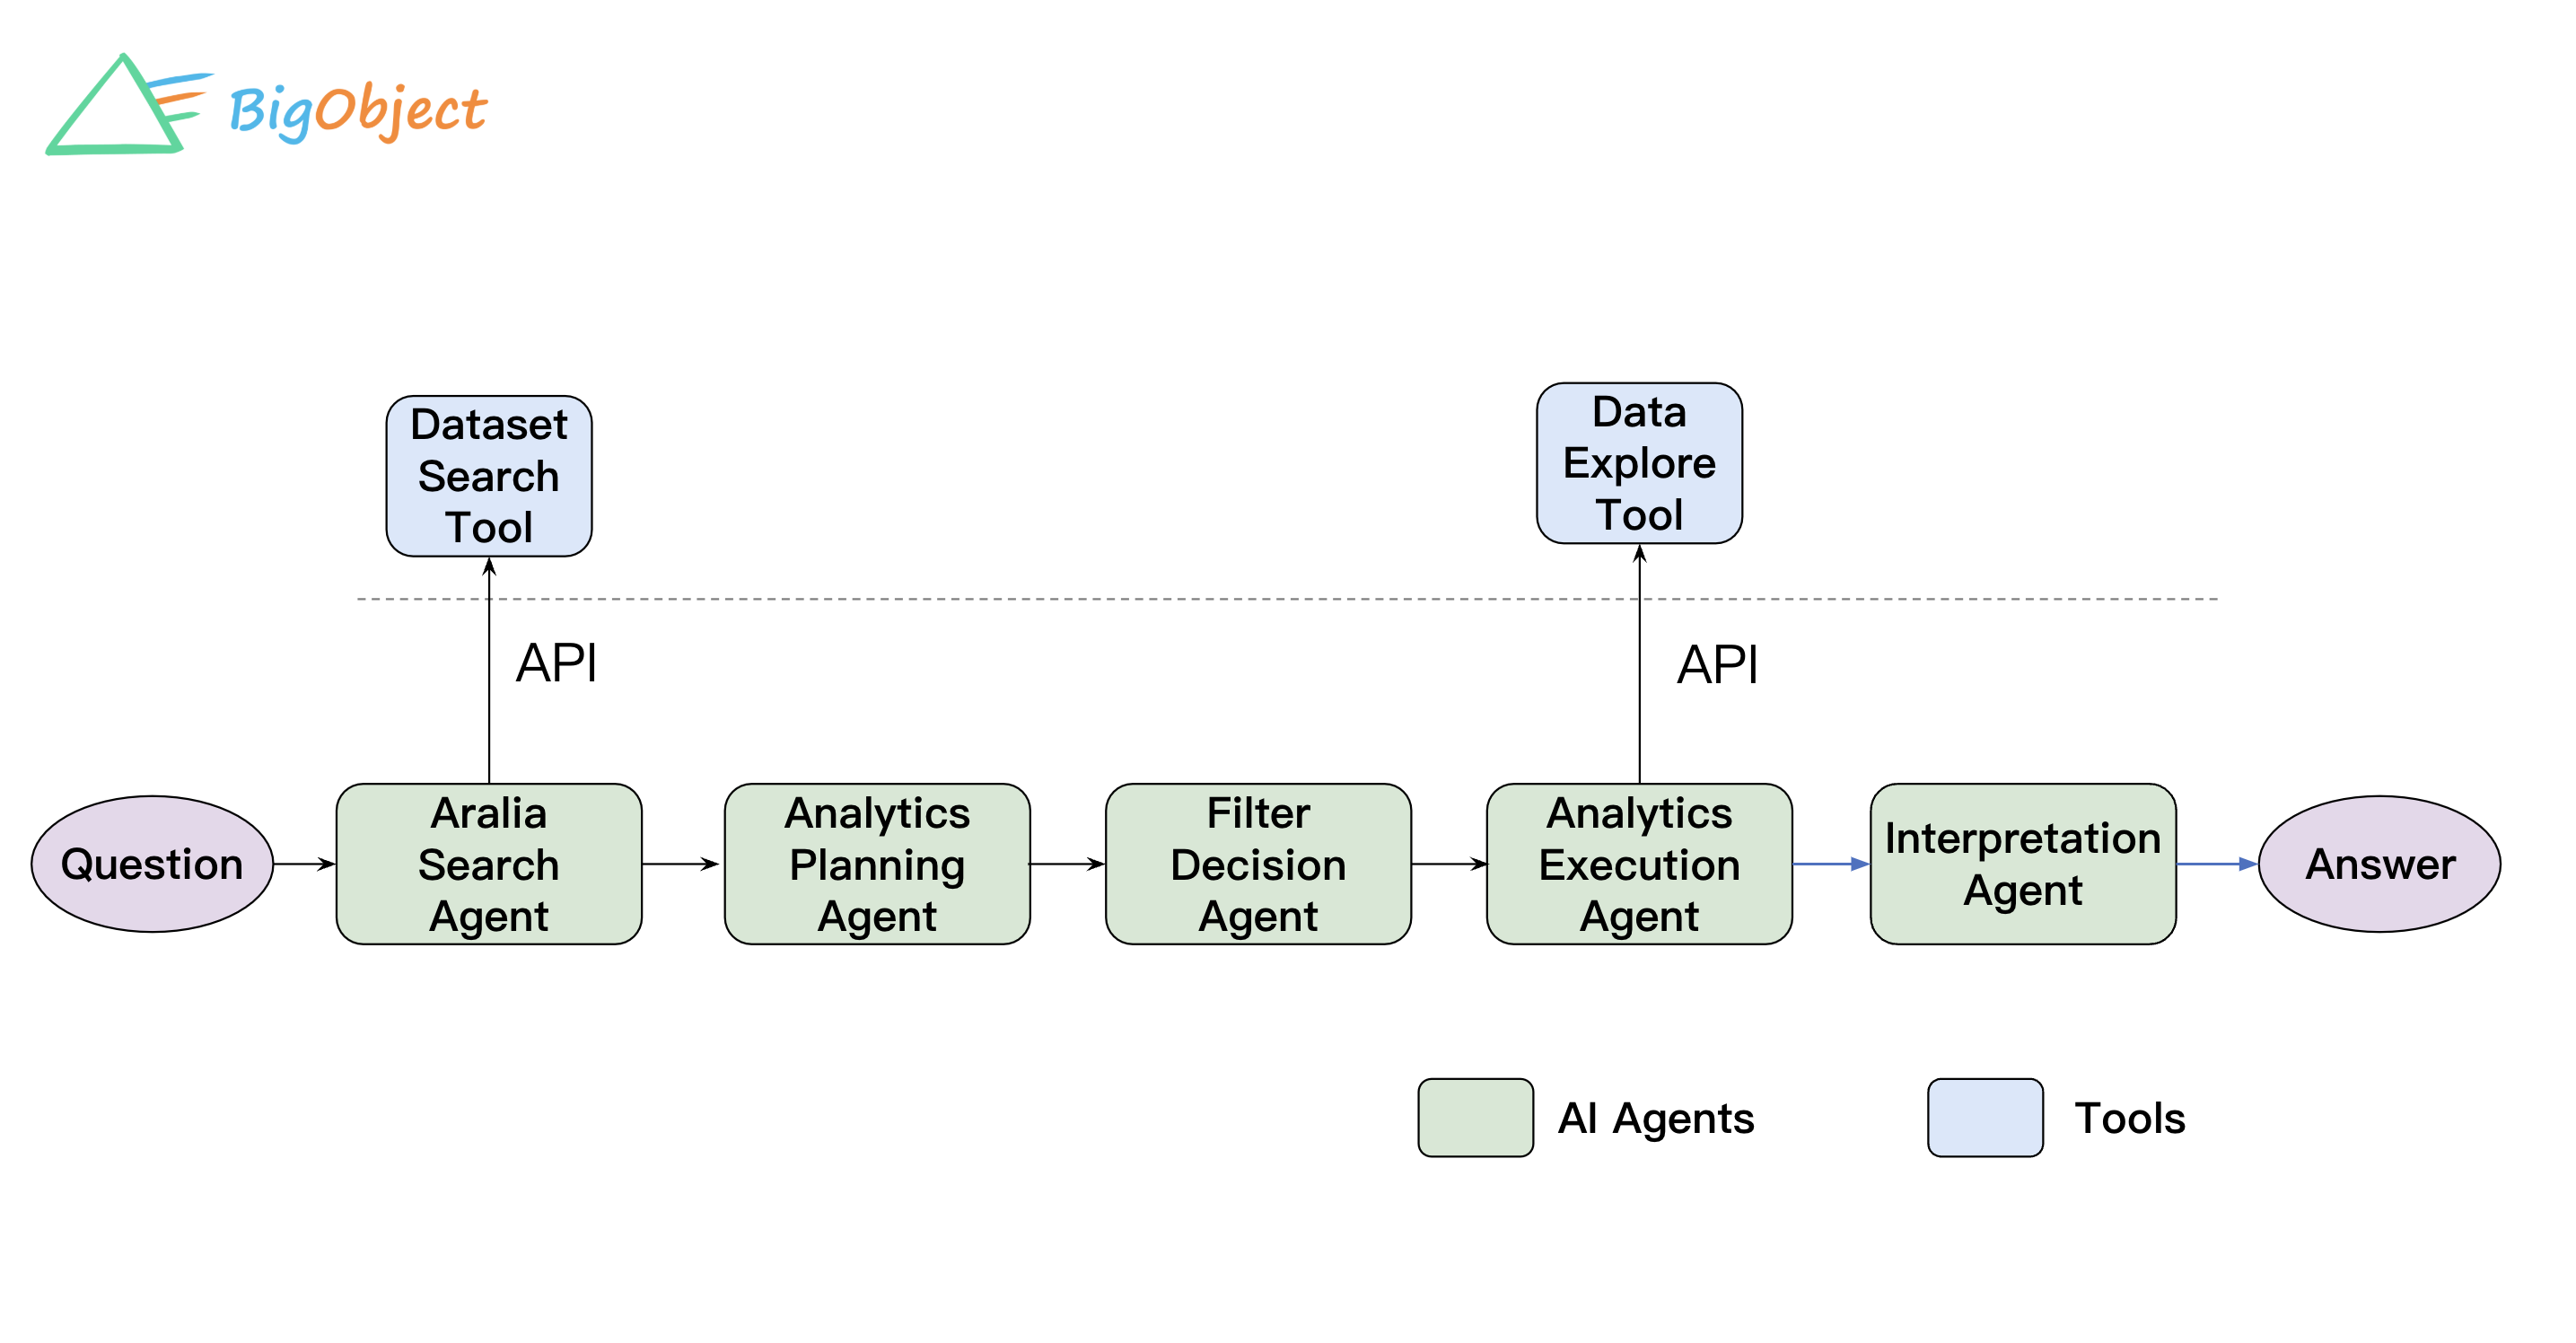

### **Try it yourself**

**Run your agent**

In [ ]:
# Run this cell to see the outputs of the complete agentic workflow.


## Enter your question within the quotation marks.
question = "Is there a relationship between the average GDP growth at purchasers' prices from 2021 to 2024 and gini coefficient of each state in Malaysia in 2024?"


assistant_graph = AssistantGraph()

# Define a request
request = {
    "question": question,
    "ai": os.getenv("GEMINI_API_KEY"), ## Advanced option: select and set different LLMs here
    "client_id": os.getenv("ARALIA_CLIENT_ID"),
    "client_secret": os.getenv("ARALIA_CLIENT_SECRET"),
    "sso_url": sso_url,
    "url":planet_url,
    "verbose":True,
    # "interpretation_prompt":"replace this text with custom prompt" ## Advanced option: uncomment to set a custom prompt for the interpretation agent
}

# Execute the workflow
response = assistant_graph(request)

# **Section 3: AI Agent Deep Dive**

Welcome! This tutorial section will walk you through how AI agents work, step by step. We'll cover the important bits, like:

- What is "State"? We'll look at how an agent understands its situation.
- What are Nodes: Think of these as the action points or decision steps for an agent.
- Writing good prompts: Learn how to ask your agent the right things to get the results you want.
- Agent steps and why they matter: We'll break down what each part of an agent does and its job in the bigger picture.

## **3.1 State Definition**



The `BasicState` class is used to manage the state of the system as it progresses through different nodes. It includes the following fields:

- **`condition`**: A string representing the current condition of the state.
- **`response`**: A generic field to store responses from nodes.
- **`question`**: The user's query.
- **`language`**: The language of the query.
- **`search_results`**: A list of search results.
- **`ai`**: The AI model used for processing.
- **`at`**: The Aralia Tools instance for interacting with the Aralia platform.
- **`google`**: The Google Custom Search instance.
- **`final_response`**: The final output of the system.
- **`url`**: The base URL for interacting with Aralia's APIs. Choose between testing data and official data.
- **`verbose`**: A flag to enable or disable verbose output.
- **`interpretation_prompt`**: A custom prompt for the interpretation agent.

The state is passed between nodes to maintain context and data throughout the workflow. Each node updates the state with its results, ensuring that subsequent nodes have access to the necessary information.

In [ ]:
class BasicState(TypedDict):
    condition: str
    response: Any
    question: str
    language: str
    search_results: Annotated[list, Any]
    ai: Any
    at: Any  # Aralia Tools instance
    google: Any
    final_response: Any
    url: Any
    verbose: Any
    interpretation_prompt: str

## **3.2 Node Definitions**


Nodes are modular functions that perform specific tasks in the workflow. Each node takes the `state` as input, processes it, and returns an updated state.


### **3.2.1 `aralia_search_agent`**

- **Purpose**: Searches for datasets on the Aralia platform that are relevant to the user's query.
- **Key Steps**:
  1. Uses the `search_tool` method from `AraliaTools` to retrieve datasets.
  2. Filters datasets using a prompt template (`simple_datasets_extract_template`) and an AI model.
  3. Handles retries to ensure robust dataset extraction.
- **Output**: Updates the state with `response` containing the filtered datasets.


#### **Prompt**

The default `aralia_search_agent` prompt:

    Instruction: Strict Dataset Filtering
    Task: For the following question, retain only "directly relevant" datasets and remove all indirect or redundant ones.

    Input:

        Question: {question}

        Candidate Datasets: {datasets}

#### **Try it yourself**


**Run your agent**

In [ ]:
# Run this cell to see the outputs of the aralia_search_agent.


## Enter your question within the quotation marks.
question  = "What is the average GDP growth rate of each state in Malaysia in 2019?"


# Initialize Aralia Tools
aralia = aralia_tools.AraliaTools(
    client_id=os.getenv("ARALIA_CLIENT_ID"),
    client_secret=os.getenv("ARALIA_CLIENT_SECRET"),
    sso_url=sso_url,
    url=planet_url
)

# Define state
state = {
    "question": question,
    "at": aralia,
    # "ai": ChatAnthropic(
    #     api_key=os.environ["ANTHROPIC_API_KEY"], model="claude-3-5-sonnet-20240620", temperature=0),
    # "ai": ChatOpenAI(
    #     api_key=os.environ["OPENAI_API_KEY"], model="gpt-4o", temperature=0),
    "ai": ChatGoogleGenerativeAI(
        api_key=os.environ["GEMINI_API_KEY"], model="gemini-2.0-flash", temperature=0), # Please use Gemini for a smooth experience. Advanced users may try with a different LLM.
    "verbose":True,
}

# Run the node
response1 = node.aralia_search_agent(state)
# response1

### **3.2.2 `analytics_planning_agent`**


- **Purpose**: Plans the analytics process by selecting relevant columns and chart specifications for the datasets.
- **Key Steps**:
  1. Retrieves column metadata for the datasets using `column_metadata_tool`.
  2. Uses a prompt template (`chart_ploting_template`) to generate chart specifications.
  3. Filters and formats the datasets based on the AI response.
  4. Handles retries for robust processing.
- **Output**: Updates the state with `response` containing the filtered datasets and chart specifications.

#### **Prompt**

The default `analytics_planning_agent` prompt:


    # [Role and Core Objective]
    You are a senior data analyst expert, skilled in data exploration and correlation analysis, and proficient in designing effective data visualizations.
    Your objective is: Based on the user's question, analyze each provided dataset, and for **each dataset deemed relevant**, propose **only one specific chart proposal** that most effectively answers the question.

    # [Input Information]
    - **Question:** {question}
    - **Datasets:** {datasets} (This should include dataset descriptions, column names, column types, etc. - metadata)
    - **admin_level:** {admin_level}

    # [Execution Steps]
    Please strictly write down your thought process for each step.

    **Phase 1: Problem Analysis**
        * Deeply understand the intent of the user's `Question`, break it down, and identify the key entities, metrics, dimensions, and their potential relationships that need to be analyzed.
        * Thought Record: Document your understanding and analysis of the question.*

    **Phase 2: Datasets Removal**
        * Retain only the best datasets to the question, remove the worse ones.*

    **Phase 3: Column Selection**
        * For best datasets, identify the **minimum necessary set of columns** required to answer the `Question`.

    **Phase 4: Charting Specification(Per Dataset)**
        a. Identify required data components:
            - Metrics: Quantitative fields for measurement
            - Dimensions: Categorical fields for grouping
        b. If fields's type is **date/datetime/space/nominal/ordinal/point/line/polygon** specify fields to x (if necessary)
        c. If fields's type is **integer/float** specify fields to y (if necessary)

    **Phase 5: Filtering Specification(Per Dataset)**
        a. Define filter parameters (including any dual-purpose fields used in both x/y and filtering):
            - Temporal Scope: Date/time ranges (if necessary)
            - Spatial Boundaries: Geographic constraints (if necessary)
            - Category Filters: Specific categorical values
        b. Specify required filter fields (including any dual-purpose fields used in both x/y and filtering)

    **Phase 6: Format and Calculation Specification(Per Dataset)**
        a.If field's type is **date, datetime**,
        - "format" should be one of:
            ["year", "quarter", "month", "week", "date", "day", "weekday", "year_month", "year_quarter", "year_week", "month_day", "day_hour", "hour", "minute", "second", "hour_minute", "time"].

        b.If field's type is **space, point, line, polygon**.
        - Please carefully consider user's question to fill the most general admin_level_x(lowest number) to "format".

        c.If field's type is **nominal, integer, float**
        - "format" is ""

        d.If field's type is **integer, float**
        - "calculation" should be one of:
            ["count", "sum", "avg", "min", "max", "distinct_count"].
   
        e.If field's type is **nominal**
        - "calculation" should be one of:
            ["count", "distinct_count"]

    **Phase 7:Final Output Generation**
        a. Apply Phase 4 to x and y.
        b. Apply Phase 5 to filter.
        c. Apply to the `json_format` specified below.

    json_format:
    {{
        "charts": [
            {{
                "id": "dataset_id",
                "name": "dataset_name
                "x":[
                    {{
                        "columnID": "column_id",
                        "name": "filed_displayName",
                        "type":"",
                        "format": "",
                    }}
                ],
                "y":[
                    {{
                        "columnID": "column_id",
                        "name": "filed_displayName",
                        "type":"",
                        "calculation": "aggregate_function"
                    }}
                ],
                "filter":[
                    {{
                        "columnID": "column_id",
                        "name": "filed_name",
                        "calculation": "aggregate_function",
                        "type":"",
                        "format": "",
                        "operator":"",
                        "value": ["filter_value"]
                    }}
                ]
            }},
            ...
        ]
    }}

  

#### **Try it yourself**


In [ ]:
## Run this cell to see the outputs of the analytics_planning_agent.

response2 = node.analytics_planning_agent(state | response1)
response2['response']

### **3.2.3 `filter_decision_agent`**


- **Purpose**: Determines the filtering criteria for the datasets based on the user's query.
- **Key Steps**:
  1. Uses the `filter_option_tool` method from `AraliaTools` to retrieve filter options.
  2. Generates a filtering prompt using `query_generate_template`.
  3. Processes the AI response to finalize the filtering criteria.
- **Output**: Updates the state with `response` containing the filtered datasets and their filtering criteria.


#### **Prompt**

The default `filter_decision_agent` prompt:


    You are a senior data analyst specializing in statistical data analysis. You excel at extracting insights from data and identifying relationships between different datasets.

    You will be given an input JSON structure representing a potential data analysis setup, including pre-defined 'x', 'y', and 'filter' fields. You will also receive a user question.

    Your task is to generate an output JSON based *strictly* on the input JSON structure and the user question, following these precise rules:

    User Question: {question}

    Input JSON: {response}

    Output JSON Generation Rules:

    1.  **Preserve Overall Structure:** The output JSON must maintain the exact same top-level keys (`id`, `name`, `description`, `siteName`, `sourceURL`, `x`, `y`, `filter`) as the input JSON. The content of the `x` and `y` arrays must be copied verbatim from the input.
    2.  **Maintain Filter Array Integrity:**
        * The `filter` array in the output JSON **MUST** contain the exact same number of objects as the input `filter` array.
        * Each object within the output `filter` array **MUST** correspond to an object in the input `filter` array, identified by the **exact same `columnID`**, and in the **same order**.
        * **DO NOT ADD any new objects** to the `filter` array.
        * **DO NOT REMOVE any objects** from the `filter` array.
        * **DO NOT CHANGE the `columnID`** or any other fields (like `type`, `description`, `displayName`, `format`) within the existing filter objects, **EXCEPT** for `operator` and `value`.
    3.  **Modify Only `operator` and `value`:** For **each** filter object already present in the **input** `filter` array:
        * Carefully analyze the `User Question` to determine if it specifies conditions related to this filter object's `columnID` (or its `displayName`/`description`).
        * **If conditions ARE specified** in the user question for this filter:
            * Set the `operator` based on the filter object's `type`:
                * `date`/`datetime`/`nominal`/`space`: `operator` MUST be `"in"`
                * `integer`/`float`: `operator` MUST be "range"/"lt"/"gt"/"lte"/"gte"
            * Set the `value` based **strictly** on the conditions identified in the user question, formatted correctly for the chosen `operator` and `type`.
                * For `nominal` type: Please carefully analyze user's question step by step then fill "value".
                    Some institutions or buildings may have a name associated with a certain city or district but are physically located elsewhere.
                    For example, the Taipei Motor Vehicles Office is actually located in New Taipei City.
    4.  **Strict Compliance:** Adhere strictly to these rules. Do not introduce any modifications or elements not explicitly allowed. Focus solely on adjusting the `operator` and `value` of the pre-existing filter objects based on the user's query.


#### **Try it yourself**

In [ ]:
## Run this cell to see the outputs of the filter_decision_agent.

response3 = node.filter_decision_agent(state | response2)
response3['response']

### **3.2.4 `analytics_execution_agent`**


- **Purpose**: Executes the analytics process by exploring the datasets and generating visualizations.
- **Key Steps**:
  1. Uses the `explore_tool` method from `AraliaTools` to retrieve and process data.
  2. Generates CSV files of the datasets.
- **Output**: Updates the state with `search_results` containing the processed datasets.


#### **Try it yourself**

In [ ]:
## Run this cell to see the outputs of the analytics_execution_agent.

response4 = node.analytics_execution_agent(state | response3)
response4

### **3.2.5 `interpretation_agent`**


- **Purpose**: Interprets the results of the analytics process and generates a final response for the user.
- **Key Steps**:
  1. Constructs a message for the AI model with the user's query and the processed data.
  2. Invokes the AI model to generate a concise, 300-word summary.
- **Output**: Updates the state with `final_response` containing the AI-generated summary.


#### **Prompt**

The default `interpretation_agent` prompt:

    I have already gathered relevant information based on the user's question.
    Please analyze the information above in detail, then provide a detailed answer to the question, and give a conclusion within 300 words.
    Please help me analyze this data carefully.
    Please provide with English.

**Advanced option: Set your own prompt for the interpretation agent.**

In [ ]:
## Uncomment the following line of code and run this cell to overide the default prompt with your own

# state["interpretation_prompt"] = "replace this text with custom prompt"

In [ ]:
## Uncomment the following line of code to revert to the default prompt

# state["interpretation_prompt"] = None

#### **Try it yourself**

In [ ]:
## Run this cell to see the outputs of the interpretation_agent.

response5 = node.interpretation_agent(state | response4)
response5

## **3.3 Error Handling**


Each node includes error handling mechanisms to ensure robustness:
  - **Retries**: Nodes like `aralia_search_agent`, `analytics_planning_agent`, and `filter_decision_agent` retry operations up to 5 times.
  - **Exceptions**: Nodes raise `RuntimeError` if critical operations fail (e.g., dataset retrieval, AI response generation).
  - **Verbose output**: Step by step processes are printed to the console if `state['verbose']` is set to `True`.

## **3.4 Integration with Aralia APIs**

The `AraliaTools` class provides methods for interacting with Aralia's APIs, such as searching for datasets, retrieving column metadata, and exploring data.

In [ ]:
# Initialize Aralia Tools
aralia = AraliaTools(
    client_id=os.getenv("ARALIA_CLIENT_ID"),
    client_secret=os.getenv("ARALIA_CLIENT_SECRET"),
    sso_url=sso_url,
    url=planet_url,
)

# Search for datasets
datasets = aralia.search_tool("What is the average GDP growth rate of each state in Malaysia in 2019?")
pd.DataFrame(datasets)

## **3.5 Conclusion**


This deepdive demonstrates the modular design of the AI agent system and its integration with Aralia's APIs. By running the provided code snippets, you can explore the functionality of each component interactively.